In [25]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import add_funcs as af
import scipy.integrate as integrate

from astropy.io import ascii

In [26]:
#Constants

M_sun = 1.989*10**33 #g
pc = 3.086*10**18 #cm
Mpc = 10**6 * pc
c = 299792.458 #kms

In [27]:
#Set the read in conditions and assumed values

#This is the range which at least should be present to select the file
lambda_min = 5000 #Å, have at least Mg I
lambda_max = 8000 #Å

nebular_start = 120 #days, define the start of the nebular phase
nebular_end = 450 #days, define the end of the nebular phas



## Read in the models

In [28]:
project_names = ["NII_he3p30_AJ_10_90", "NII_he3p30_AJ_20_80",
                 "NII_he3p30_AJ_30_70", "NII_he3p30_AJ_60_40",
                 "NII_he4p00_AJ_10_90", "NII_he4p00_AJ_20_80",
                 "NII_he4p00_AJ_30_70", "NII_he4p00_AJ_60_40",
                 "NII_he6p00_AJ_10_90", "NII_he6p00_AJ_20_80",
                 "NII_he6p00_AJ_30_70", "NII_he6p00_AJ_60_40" ]

core_percent = [10, 20, 30, 60, 10, 20, 30, 60, 10, 20, 30, 60]
masses = [3.3, 3.3, 3.3, 3.3, 4.0, 4.0, 4.0, 4.0, 6.0, 6.0, 6.0, 6.0]

colours = ['blue', 'red', 'green'] #for the plotting
zoom = [3500, 9500] #Give the region to be zoomed in at.

deps = []
wavelengths, fluxes, NII_fluxes = [], [], []

for i in range(len(project_names)):
    dep_path = "/home/stba7609/Documents/Projects/300d/" + project_names[i] + "/out/main/dep.dat"
    data = open(dep_path, 'r')
    
    counter = 0
    print("Mass & Core_percent:", masses[i], core_percent[i])
    for line in data:
        if counter == 0:
            deps.append(float(line))
        counter += 1
        
    #===================================================================================================
    spectrum_path = "/home/stba7609/Documents/Projects/300d/" + project_names[i] + "/out/modelspectra/spectrum.datrun001"
    data = ascii.read(spectrum_path)
    
    wavelength_raw = data['col1'] #In Ångström
    flux_raw = data['col2'] #In erg s-1 cm-2 Å-1
    NII_flux_raw = data['col15'] #See ABIN Codes on github
    
    wavelength_raw = af.redshift_correct_wl(wavelength_raw, 10) #Correct redshift for models, which are all at 10 Mpc
    
    
    relevant_index = np.where((wavelength_raw > 6450) * (wavelength_raw < 6700))[0][17]
    highest, index = 0, 0
    for i in range(6, 150):
        col = 'col' + str(i)
        val = data[col][relevant_index]
        if val > highest:
            highest = val
            index = i
    print("Fraction of NII radiation at peak & strongest emitting element: ", NII_flux_raw[relevant_index]/flux_raw[relevant_index], index)
    
    filter1 = (wavelength_raw < zoom[1])*(wavelength_raw > zoom[0])
    
    wavelength = wavelength_raw[filter1]
    flux = flux_raw[filter1]
    NII_flux = NII_flux_raw[filter1]
    
    wavelengths.append(wavelength)
    fluxes.append(flux)
    NII_fluxes.append(NII_flux)

FileNotFoundError: [Errno 2] No such file or directory: '/home/stba7609/Documents/Projects/300d/NII_he3p30_AJ_10_90/out/main/dep.dat'

## Compare with the observations

In [5]:
print(af.v_from_labda(6581, 6565))

729.7538753280207


In [ ]:
#Read in the data
base_path = '/home/stba7609/Documents/Observations/'

sn_names = np.array(['2007Y', '2008ax', '2011dh', '2013ge', 'iPTF13bvn',
                    '1990I', '2004ao', '2004dk', '2004gq', '2007C',
                    '2012au', '2014C', '2015Q'])
expl_dates = np.array([2454146.50000, 2454528.50000, 2455712.50000, 2456605.50000, 2456460.50000,
                      2447990.50000, 2453055.50000, 2453218.50000, 2453340.50000, 2454101.50000,
                      2455987.50000, 2456651.50000, 2457190.50000])
expl_dates_exact = np.array([True, True, True, True, True,
                            False, False, False, False, False,
                            False, False, False]) #If unkown, take 20 days before peaklight or at discovery (if either no peaklight given or further than 20 days before peak)

vlines = np.array([3500, 4500, 3500, 3500, 3500,
                  3500, 3500, 3500, 3500, 3500,
                  3500, 3500, 3500]) #kms
recession_velocities = np.array([0, 565, 600, 0 ,0,
                                0, 0, 0, 0, 0,
                                0, 0, 0]) #kms. 0 means the value is not known
Ni_masses = np.array([0.075, 0.10, 0.075, 0.075, 0.075,
                     0.075, 0.075, 0.075, 0.075, 0.075,
                     0.075, 0.075, 0.075])*M_sun

redshifts = np.array([0.004657 ,0.001931 ,0.002,0.004356,0.00449,
                     0.009703, 0.005641, 0.0052, 0.006468, 0.005611,
                     0.0045, 0.002722, 0.00792])
distances = af.z_to_r(redshifts)*Mpc

counter = 0

epochs, NII_fluxes = [], []

for i in range(len(sn_names)):
    
    #Read in the specific SN folder
    sn_name = sn_names[i]
    observations = os.listdir(path = base_path + sn_name )
    
    info_file = ascii.read(base_path + sn_name + '/wiserep_spectra.csv',
                          delimiter = ',')
    
    expl_date = expl_dates[i]
    
    
    #Now read each observation of that SN, get its integrated NII and store those
    local_epochs = [] #days, time since explosion
    local_NII_fluxes = []
    for j in range(len(observations)-1):
        
        distance = distances[i]
        vline = vlines[i]
        M_Ni = Ni_masses[i]
        recession_velocity = recession_velocities[i]
        redshift = redshifts[i]
        
        #Make sure the file ticks all boxes to be considered a good spectrum
        condition1 = (info_file['Lambda-min'][j] <= lambda_min)
        condition2 = (info_file['Lambda-max'][j] >= lambda_max)
        condition3 = (info_file['JD'][j]-expl_date >= nebular_start) 
        condition4 = (info_file['JD'][j]-expl_date <= nebular_end)
        
        
        if condition1 and condition2 and condition3 and condition4:
            counter += 1
            
            epoch = info_file['JD'][j]-expl_date
            local_epochs.append(epoch)
            
            print(j, info_file['Ascii file'][j], info_file['JD'][j]-expl_date)
            
            
            
            #Read in the data
            this_observation_data = np.loadtxt(base_path + sn_name + '/' + info_file['Ascii file'][j])
            
            
            #Apply some normalisations
            if (np.max(this_observation_data[:, 1]) < 7) *(np.max(this_observation_data[:, 1]) > 5.5):
                wl, flux = af.redshift_correct_wl(this_observation_data[:, 0], own_z = redshift), this_observation_data[:, 1]/(2*10**15)
            elif np.max(this_observation_data[:, 1]) > 10**-9:
                wl, flux = af.redshift_correct_wl(this_observation_data[:, 0], own_z = redshift), this_observation_data[:, 1]/10**15
            else:
                wl, flux = af.redshift_correct_wl(this_observation_data[:, 0], own_z = redshift), this_observation_data[:, 1]
                #wl = this_observation_data[:, 0]
                
                
            #Compare to models
            if abs(epoch-300) < 0:
                
                epoch_correction = np.exp(-2*(epoch-300)/111.4)
                
                for q in range(len(project_names)):
                    
                    if q < 4:
                        model_ni = 0.0221 * M_sun
                    elif q > 3 and q < 8:
                        model_ni = 0.0187 * M_sun
                    else:
                        model_ni = 0.051 * M_sun
                        
                    Ni_correction = M_Ni/model_ni
                    distance_correction = 1/(((distance/Mpc)/10)**2)
                    total_correction = epoch_correction*Ni_correction*distance_correction
                    
                    
                    print(distance/Mpc, ((distance/Mpc)/10)**2)
                    plt.plot(wavelengths[q], fluxes[q]*total_correction, linestyle = '--', label = project_names[q]) #((distance/Mpc)/10)**2
                    plt.plot(wl, flux, label = sn_name) #Correct for distance difference
                    plt.legend()
                    plt.show()
            
            #Integrate the fluxes
            integrated_NII_flux_my_method, popt = af.observed_flux_from_fit(wl, flux, plot = True)
            integrated_NII_flux_AJ = af.observed_flux_AJ(wl, flux, vline, 6300, 6363)
            
            surface = 4*np.pi*distance**2
            true_integrated_NII_flux_my_method = integrated_NII_flux_my_method*surface
            true_integrated_NII_flux_AJ = integrated_NII_flux_AJ*surface
            
            normalisation_mask = (wl > lambda_min) * (wl < lambda_max)
            
            #Change here
            #OI_flux = af.gaussian(wl, 6316, popt[0], popt[2])
            #my_normalisation = integrate.cumtrapz(OI_flux, wl)[-1]*surface
            
            my_normalisation = integrate.cumtrapz(flux[normalisation_mask], wl[normalisation_mask])[-1]*surface
            
            AJ_normalisation = af.Lnorm_AJ(epoch, M_Ni)
            
            print("The NII doublet carries: ", "{0:.3g}".format(true_integrated_NII_flux_my_method*100/my_normalisation), "% of the selected region")
            print("The NII doublet carries: ", "{0:.3g}".format(true_integrated_NII_flux_my_method*100/AJ_normalisation), "% of the selected region with AJ")
            
            local_NII_fluxes.append(true_integrated_NII_flux_AJ/AJ_normalisation)
            
    epochs.append(local_epochs)
    NII_fluxes.append(local_NII_fluxes)
    

fig, ax = plt.subplots(1)    
for k in range(len(NII_fluxes)):
    ax.plot(np.array(epochs[k])[np.array(NII_fluxes[k]) < 1], np.array(NII_fluxes[k])[np.array(NII_fluxes[k]) < 1], label = sn_names[k])
    
ax.set_xlim(0, 600)
ax.legend()
plt.show()

print("The counter is: ", counter)

## Find best fitting model for 2011dh

In [30]:
for i in range(len(sn_names)):
    if i != 2:
        pass
    else:
        #Read in the specific SN folder
        sn_name = sn_names[i]
        observations = os.listdir(path = base_path + sn_name )

        info_file = ascii.read(base_path + sn_name + '/wiserep_spectra.csv',
                              delimiter = ',')

        expl_date = expl_dates[i]


        #Now read each observation of that SN, get its integrated NII and store those
        dh_epochs = [] #days, time since explosion
        dh_wls, dh_fluxes = [], []
        for j in range(len(observations)-1):

            distance = distances[i]
            vline = vlines[i]
            M_Ni = Ni_masses[i]
            recession_velocity = recession_velocities[i]
            redshift = redshifts[i]

            #Make sure the file ticks all boxes to be considered a good spectrum
            condition1 = (info_file['Lambda-min'][j] <= lambda_min)
            condition2 = (info_file['Lambda-max'][j] >= lambda_max)
            condition3 = (info_file['JD'][j]-expl_date >= nebular_start) 
            condition4 = (info_file['JD'][j]-expl_date <= nebular_end)


            if condition1 and condition2 and condition3 and condition4:
                counter += 1

                epoch = info_file['JD'][j]-expl_date
                local_epochs.append(epoch)

                print(j, info_file['Ascii file'][j], info_file['JD'][j]-expl_date)



                #Read in the data
                this_observation_data = np.loadtxt(base_path + sn_name + '/' + info_file['Ascii file'][j])


                #Apply some normalisations
                if (np.max(this_observation_data[:, 1]) < 7) *(np.max(this_observation_data[:, 1]) > 5.5):
                    wl, flux = af.redshift_correct_wl(this_observation_data[:, 0], own_z = redshift), this_observation_data[:, 1]/(2*10**15)
                elif np.max(this_observation_data[:, 1]) > 10**-9:
                    wl, flux = af.redshift_correct_wl(this_observation_data[:, 0], own_z = redshift), this_observation_data[:, 1]/10**15
                else:
                    wl, flux = af.redshift_correct_wl(this_observation_data[:, 0], own_z = redshift), this_observation_data[:, 1]
                    #wl = this_observation_data[:, 0]
                    
                dh_epochs.append(epoch)
                dh_wls.append(wl)
                dh_fluxes.append(flux)
                
                
dh_epochs = np.array(dh_epochs)
dh_wls = np.array(dh_wls)
dh_fluxes = np.array(dh_fluxes)

0 2011dh_2011-10-30_03-32-05_Ekar_AFOSC_None.dat 152.14728009980172
1 2011dh_2011-11-02_05-07-29_CA-2.2m_CAFOS_None.dat 155.21353009995073
5 2011dh_2011-12-18_00-00-00_Lick-3m_KAST_None.flm 201.0
6 SN_2011dh_2011-12-18_13-23-31_Lick-3m_KAST_UCB-SNDB_0.flm 201.55799769982696
7 2011dh_2011-12-19_04-20-17_WHT-4.2m_ISIS_None.dat 202.18075230019167
10 2011dh_2011-12-24_00-00-00_Lick-3m_KAST_None.flm 207.0
11 SN_2011dh_2011-12-24_14-03-50_Lick-3m_KAST_UCB-SNDB_0.flm 207.5859953998588
12 2011dh_2012-01-25_02-50-38_NOT_ALFOSC_None.dat 239.1184954000637
13 2011dh_2012-02-23_00-00-00_Lick-3m_KAST_None.flm 268.0
14 SN_2011dh_2012-02-23_10-59-31_Lick-3m_KAST_UCB-SNDB_0.flm 268.4579977001995
16 2011dh_2012-03-18_00-00-00_NOT_ALFOSC_None.dat 292.0
17 2011dh_2012-03-27_03-22-15_WHT-4.2m_ISIS_None.dat 301.1404514000751
22 2011dh_2012-05-24_01-19-38_GTC_OSIRIS_None.dat 359.0553008997813
23 2011dh_2012-07-19_23-11-29_GTC_OSIRIS_None.dat 415.9663078999147


/tmp/ipykernel_6947/3188855080.py:62: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  dh_wls = np.array(dh_wls)
/tmp/ipykernel_6947/3188855080.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  dh_fluxes = np.array(dh_fluxes)


In [31]:
plt.rcParams["font.size"] = 20

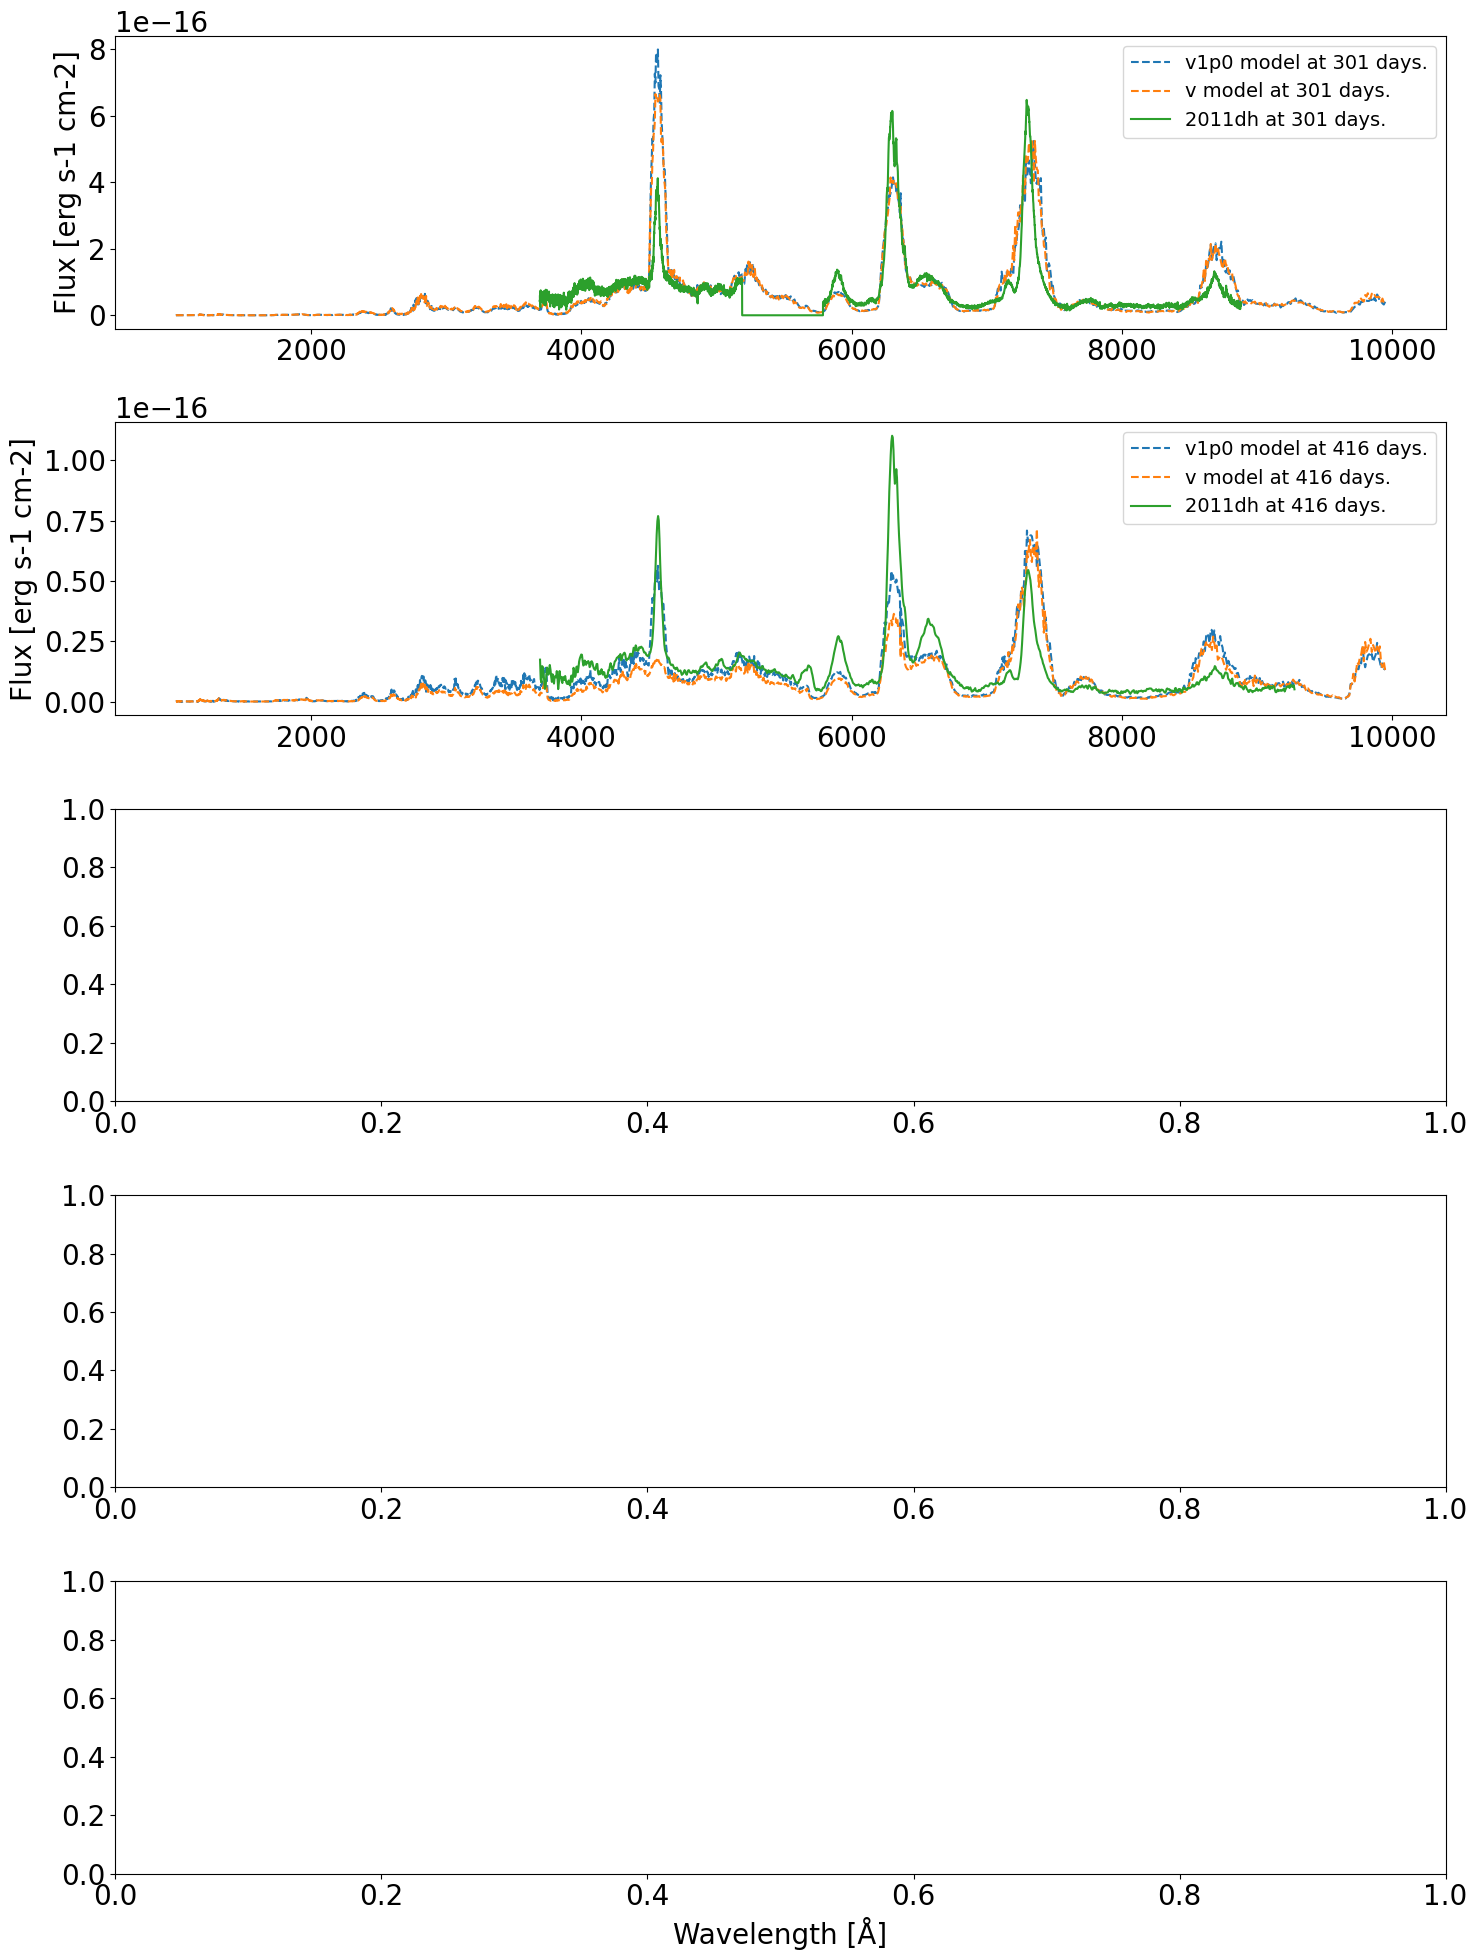

In [35]:
wl_list_333070, flux_list_333070, flux_list_ca, flux_list_ni, flux_list_mg = [], [], [], [], []
old_wl_list_333070, old_flux_list_333070, old_flux_list_ca, old_flux_list_ni, old_flux_list_mg = [], [], [], [], []

string_mass, string_mixing = '4p00', '10_90'
string_epochs = ['300d', '400d']#['200d', '250d', '300d', '350d', '400d']
epochs = np.array([300, 400])#np.array([200, 250, 300, 350, 400])

for l in range(len(string_epochs)):
    
    epoch = string_epochs[l]
    model_name = '/NII_he' + string_mass + '_AJ_' + string_mixing
    spectrum_path = "/home/stba7609/Documents/Projects/SUMO_Projects_v1p0/" + epoch + model_name + "/out/modelspectra/spectrum.datrun001"
    data = ascii.read(spectrum_path)

    wl_list_333070.append(data['col1'])
    flux_list_333070.append(data['col2'])
    flux_list_ca.append(data['col55'])
    flux_list_ni.append(data['col71'])
    
#==========================================================
for l in range(len(string_epochs)):
    
    epoch = string_epochs[l]
    model_name = '/NII_he' + string_mass + '_AJ_' + string_mixing
    spectrum_path = "/home/stba7609/Documents/Projects/SUMO_Projects_v/" + epoch + model_name + "/out/modelspectra/spectrum.datrun001"
    data = ascii.read(spectrum_path)

    old_wl_list_333070.append(data['col1'])
    old_flux_list_333070.append(data['col2'])
    old_flux_list_ca.append(data['col55'])
    old_flux_list_ni.append(data['col71'])
#==========================================================
    
    
fig, ax = plt.subplots(5, 1)

new_model_ni, old_model_ni, M_ni = 0.0612 * M_sun, 0.0445 * M_sun, 0.075 * M_sun #v1p0:0.0547, 0.0612, 0.0839 v:0.04, 0.0445, 0.0704
sn_name = '2011dh'
distance = 7.8*Mpc
for k in range(len(string_epochs)):
    
    local_wl, local_flux, local_ca_flux, local_ni_flux = wl_list_333070[k], flux_list_333070[k], flux_list_ca[k], flux_list_ni[k]
    old_local_wl, old_local_flux, old_local_ca_flux, old_local_ni_flux = old_wl_list_333070[k], old_flux_list_333070[k], old_flux_list_ca[k], old_flux_list_ni[k]
    
    
    closest_index = np.argmin(abs(epochs[k]-dh_epochs))
    closest_epoch = dh_epochs[closest_index]
    closest_wl, closest_flux = dh_wls[closest_index], dh_fluxes[closest_index]
    
    epoch_correction = np.exp(-2*(closest_epoch-epochs[k])/111.4)
    Ni_correction_new = M_Ni/new_model_ni
    Ni_correction_old = M_Ni/old_model_ni
    distance_correction = 1/(((distance/Mpc)/10)**2)
    total_correction_new = epoch_correction*Ni_correction_new*distance_correction
    total_correction_old = epoch_correction*Ni_correction_old*distance_correction
    
    ax[k].plot(local_wl, local_flux*total_correction_new, linestyle = '--', label = 'v1p0 model at ' + '{0:.0f}'.format(closest_epoch) + ' days.') 
    ax[k].plot(old_local_wl, old_local_flux*total_correction_old, linestyle = '--', label = 'v model at ' + '{0:.0f}'.format(closest_epoch) + ' days.') 
    
    #ax[k].plot(local_wl, local_ca_flux*total_correction, linestyle = '--', label = 'caII at ' + '{0:.0f}'.format(closest_epoch) + ' days.')
    #ax[k].plot(local_wl, local_ni_flux*total_correction, linestyle = '--', label = 'niII at ' + '{0:.0f}'.format(closest_epoch) + ' days.')
    ax[k].plot(closest_wl, closest_flux, label = sn_name + ' at ' + '{0:.0f}'.format(closest_epoch) + ' days.')
    ax[k].set_ylabel('Flux [erg s-1 cm-2]')
    ax[k].legend(fontsize = 14)

    #ax[k].set_xlim(7000, 7500)
ax[-1].set_xlabel('Wavelength [Å]')
fig.set_size_inches(15, 20)

plt.tight_layout()
#plt.savefig('Comparing_different_ff.png')
plt.show()
    

                    

## Find best fitting model for 2007Y

In [12]:
for i in range(len(sn_names)):
    if i != 0:
        pass
    else:
        #Read in the specific SN folder
        sn_name = sn_names[i]
        observations = os.listdir(path = base_path + sn_name )

        info_file = ascii.read(base_path + sn_name + '/wiserep_spectra.csv',
                              delimiter = ',')

        expl_date = expl_dates[i]


        #Now read each observation of that SN, get its integrated NII and store those
        dh_epochs = [] #days, time since explosion
        dh_wls, dh_fluxes = [], []
        for j in range(len(observations)-1):

            distance = distances[i]
            vline = vlines[i]
            M_Ni = Ni_masses[i]
            recession_velocity = recession_velocities[i]
            redshift = redshifts[i]

            #Make sure the file ticks all boxes to be considered a good spectrum
            condition1 = (info_file['Lambda-min'][j] <= lambda_min)
            condition2 = (info_file['Lambda-max'][j] >= lambda_max)
            condition3 = (info_file['JD'][j]-expl_date >= nebular_start) 
            condition4 = (info_file['JD'][j]-expl_date <= nebular_end)


            if condition1 and condition2 and condition3 and condition4:
                counter += 1

                epoch = info_file['JD'][j]-expl_date
                local_epochs.append(epoch)

                print(j, info_file['Ascii file'][j], info_file['JD'][j]-expl_date)



                #Read in the data
                this_observation_data = np.loadtxt(base_path + sn_name + '/' + info_file['Ascii file'][j])


                #Apply some normalisations
                if (np.max(this_observation_data[:, 1]) < 7) *(np.max(this_observation_data[:, 1]) > 5.5):
                    wl, flux = af.redshift_correct_wl(this_observation_data[:, 0], own_z = redshift), this_observation_data[:, 1]/(2*10**15)
                elif np.max(this_observation_data[:, 1]) > 10**-9:
                    wl, flux = af.redshift_correct_wl(this_observation_data[:, 0], own_z = redshift), this_observation_data[:, 1]/10**15
                else:
                    wl, flux = af.redshift_correct_wl(this_observation_data[:, 0], own_z = redshift), this_observation_data[:, 1]
                    
                dh_epochs.append(epoch)
                dh_wls.append(wl)
                dh_fluxes.append(flux)
                
                
dh_epochs = np.array(dh_epochs)
dh_wls = np.array(dh_wls)
dh_fluxes = np.array(dh_fluxes)

1 2007Y_2007-09-22_00-00-00_ESO-NTT_EMMI_SUSPECT.dat 219.0
2 2007Y_2007-10-21_00-00-00_Magellan-Clay_LDSS-3_SUSPECT.dat 248.0
4 2007Y_2007-11-30_00-00-00_VLT-UT1_FORS1_SUSPECT.dat 288.0


/tmp/ipykernel_19928/978032220.py:61: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  dh_wls = np.array(dh_wls)
/tmp/ipykernel_19928/978032220.py:62: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  dh_fluxes = np.array(dh_fluxes)


19.9447639558


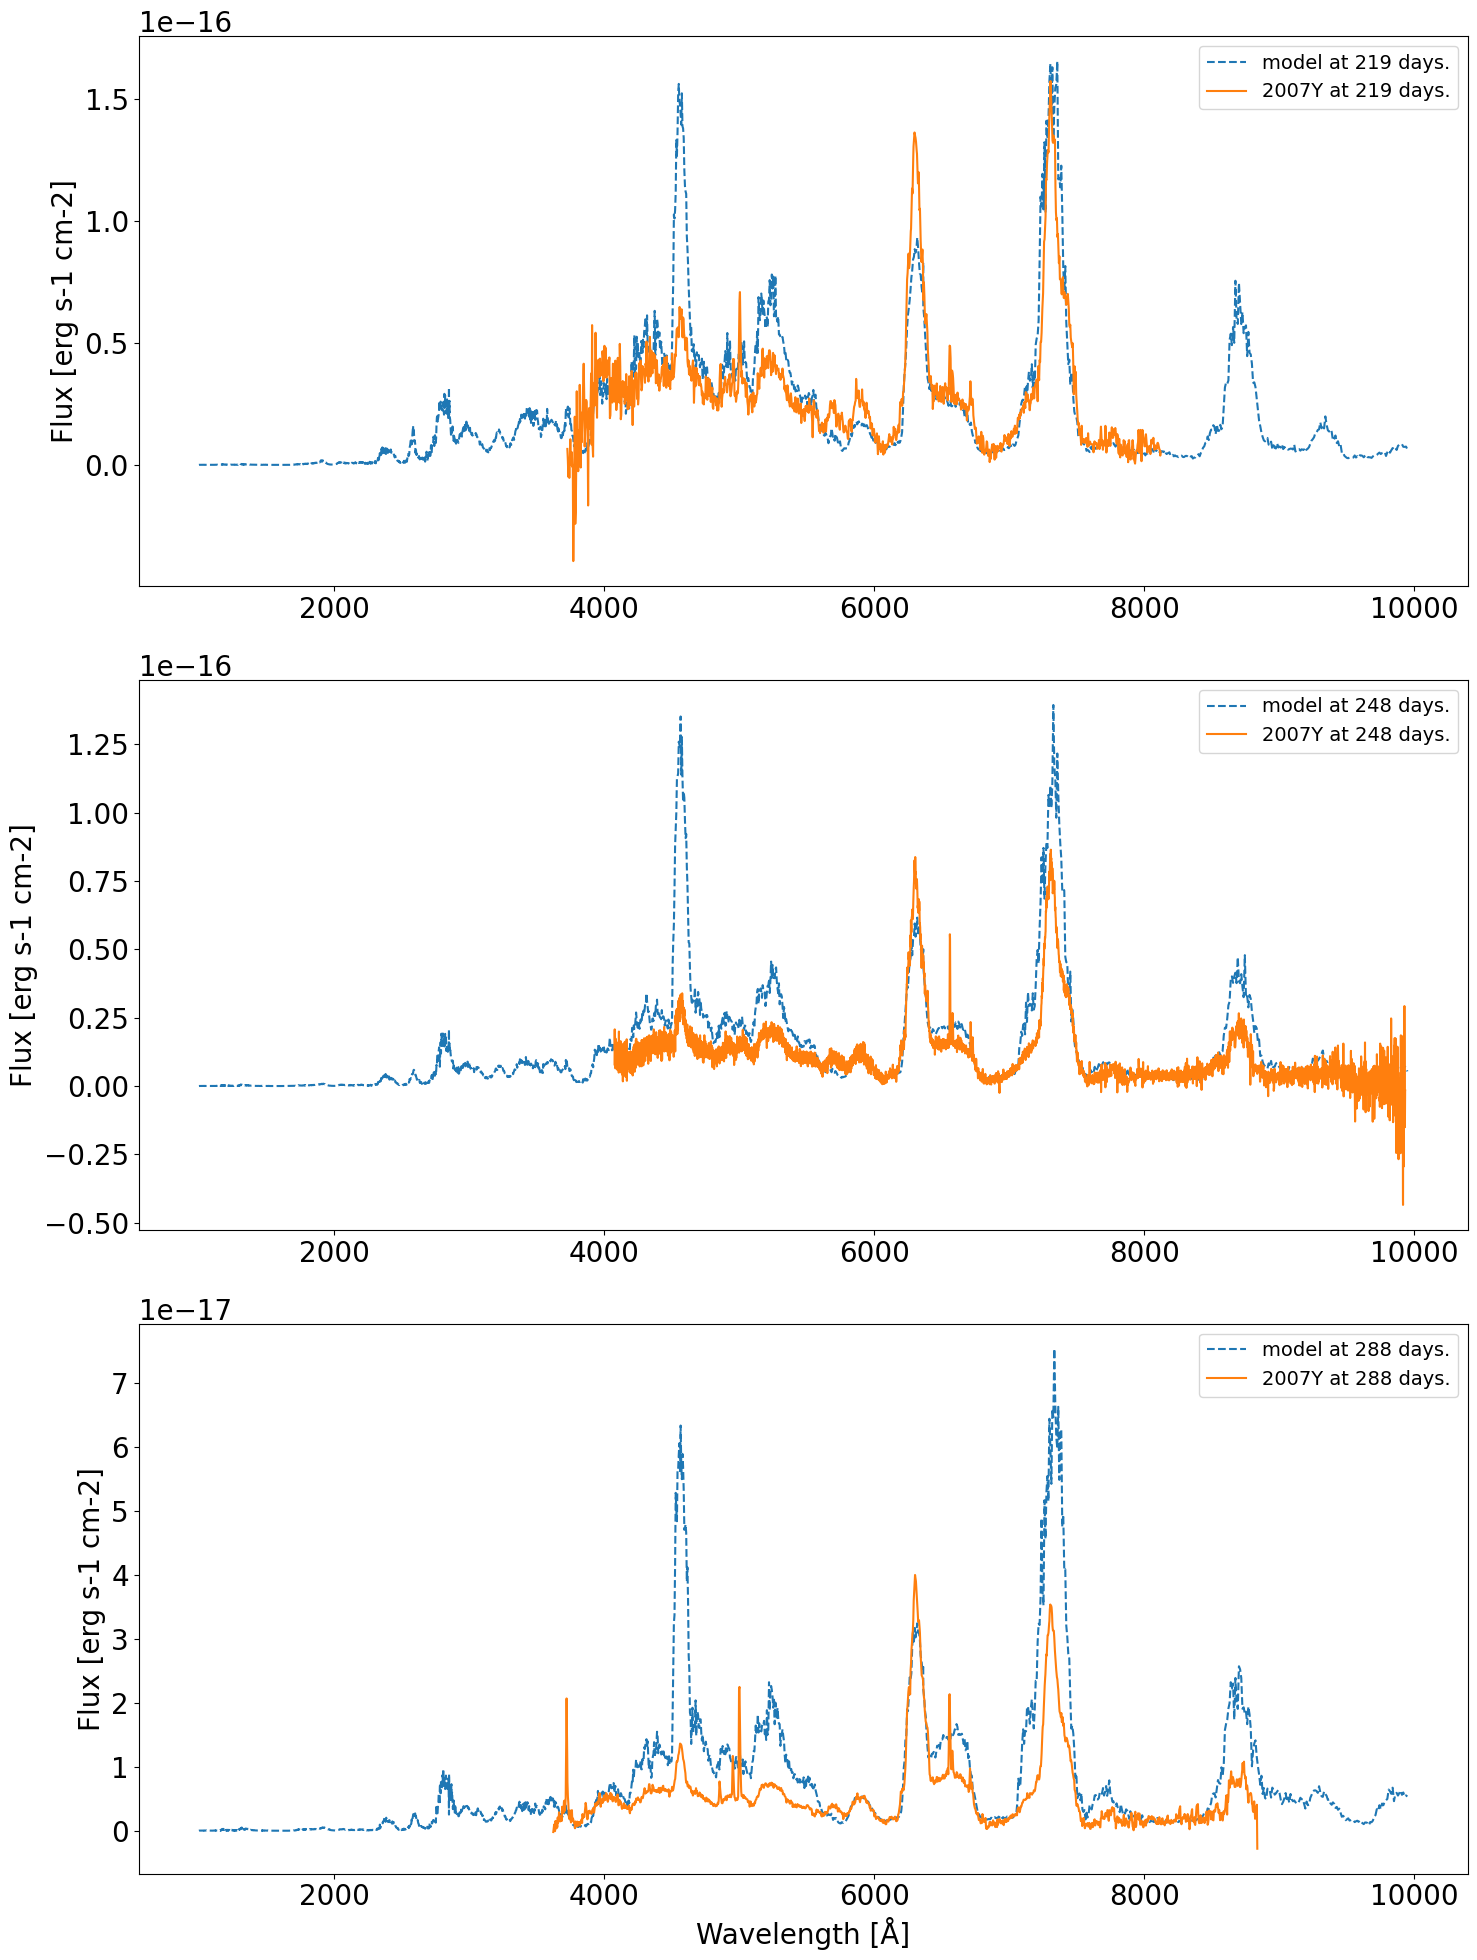

In [14]:
wl_list_333070, flux_list_333070 = [], []

string_mass, string_mixing = '3p30', '10_90'
string_epochs = ['200d', '250d', '300d', '350d', '400d']
epochs = np.array([200, 250, 300, 350, 400])

for l in range(len(string_epochs)):
    
    epoch = string_epochs[l]
    model_name = '/NII_he' + string_mass + '_AJ_' + string_mixing
    spectrum_path = "/home/stba7609/Documents/Projects/SUMO_Projects_v1p0" + epoch + model_name + "/out/modelspectra/spectrum.datrun001"
    data = ascii.read(spectrum_path)

    wl_list_333070.append(data['col1'])
    flux_list_333070.append(data['col2'])
    
    
fig, ax = plt.subplots(3, 1)

model_ni, M_Ni = 0.04 * M_sun, 0.06* M_sun #v1p0:0.0547, 0.0612, 0.0839 v:0.04, 0.0445, 0.0704
sn_name = '2007Y'
distance = distances[0]
print(distance/Mpc)
for k in range(len(string_epochs)-2):
    
    local_wl, local_flux = wl_list_333070[k], flux_list_333070[k]
    
    closest_index = np.argmin(abs(epochs[k]-dh_epochs))
    closest_epoch = dh_epochs[closest_index]
    closest_wl, closest_flux = dh_wls[closest_index], dh_fluxes[closest_index]
    
    epoch_correction = np.exp(-2*(closest_epoch-epochs[k])/111.4)
    Ni_correction = M_Ni/model_ni
    distance_correction = 1/(((distance/Mpc)/10)**2)
    total_correction = epoch_correction*Ni_correction*distance_correction
    
    ax[k].plot(local_wl, local_flux*total_correction, linestyle = '--', label = 'model at ' + '{0:.0f}'.format(closest_epoch) + ' days.') 
    ax[k].plot(closest_wl, closest_flux, label = sn_name + ' at ' + '{0:.0f}'.format(closest_epoch) + ' days.')
    ax[k].set_ylabel('Flux [erg s-1 cm-2]')
    ax[k].legend(fontsize = 14)


ax[-1].set_xlabel('Wavelength [Å]')
fig.set_size_inches(15, 20)

plt.tight_layout()
#plt.savefig('he3p30_10_90_vs_2007Y_postupdate.png')
plt.show()

## Determine O I Linewidths in observations

In [ ]:
print(af.v_from_labda(6555, 6563))

In [ ]:
for i in range(3, len(sn_names)):
    
    #Read in the specific SN folder
    sn_name = sn_names[i]
    observations = os.listdir(path = base_path + sn_name )
    
    info_file = ascii.read(base_path + sn_name + '/wiserep_spectra.csv',
                          delimiter = ',')
    
    expl_date = expl_dates[i]
    
    
    #Now read each observation of that SN, get its integrated NII and store those
    local_epochs = [] #days, time since explosion
    local_NII_fluxes = []
    local_velocities = []
    for j in range(len(observations)-1):
        
        distance = distances[i]
        vline = vlines[i]
        M_Ni = Ni_masses[i]
        recession_velocity = recession_velocities[i]
        redshift = redshifts[i]
        
        #Make sure the file ticks all boxes to be considered a good spectrum
        condition1 = (info_file['Lambda-min'][j] <= lambda_min)
        condition2 = (info_file['Lambda-max'][j] >= lambda_max)
        condition3 = (info_file['JD'][j]-expl_date >= nebular_start) 
        condition4 = (info_file['JD'][j]-expl_date <= nebular_end)
        
        
        if condition1 and condition2 and condition3 and condition4:
            counter += 1
            
            epoch = info_file['JD'][j]-expl_date
            local_epochs.append(epoch)
            
            print(j, info_file['Ascii file'][j], info_file['JD'][j]-expl_date)
            
            
            
            #Read in the data
            this_observation_data = np.loadtxt(base_path + sn_name + '/' + info_file['Ascii file'][j])
            
            wl, flux = af.redshift_correct_wl(this_observation_data[:, 0], own_z = redshift), this_observation_data[:, 1]
            
            integrated_NII_flux_my_method, popt = af.observed_flux_from_fit(wl, flux, plot = True)
            
            OI_velocity = af.v_from_labda(6316-2*popt[2], 6316)
            local_velocities.append(OI_velocity)
            
    if sum(local_velocities) != 0:         
        print("For SN ", sn_name, " the typical OI velocities are:", np.sort(local_velocities), " with an average of: ", sum(local_velocities)/len(local_velocities))